# Regression Models

### Imports

In [3]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error

from sklearn.preprocessing import StandardScaler

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

In [80]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error

In [81]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

In [82]:
from sklearn.ensemble import RandomForestRegressor

In [83]:
from sklearn.model_selection import GridSearchCV

### Settings

In [84]:
pd.options.display.max_rows = 100 # For debugging, can be removed later

In [85]:
# Matplotlib configuration
plt.rcParams['figure.figsize'] = [15, 7]

# Random Forest Regression

### Helper functions
Sort out in the end!!!

In [86]:
def model_classification(actual, predicted):
    '''
    Prints out RSME, MAE and explained variance score
    '''
    print('-'*20)
    print(f'RMSE: {round(np.sqrt(mean_squared_error(actual, predicted)),2)}')
    print('-'*20)
    print(f'MAE: {round(mean_absolute_error(actual, predicted),2)}')
    print(f'Explained variance: {round(explained_variance_score(actual, predicted),3)}')
    print('-'*20)

In [87]:
def custom_dropper(df, cols):
    '''
    drops rows with NaNs from a dataframe based on their presence in a subset of the df
    '''
    return df[df.index.isin(df[cols].dropna().index)]
# custom_dropper(sj_train_train, my_features)

In [88]:
# This is a copy from above
def env_cols(df):
    '''
    Returns a list of only environmental variables (that can be lagged).
    '''
    cols = df.columns.to_list()
    unwanted = ['week_start_date',
                'city',
                'year',
                'weekofyear',
                'month',
                'total_cases',
                'total_cases_o_seas',
                'total_cases_wo_seas'
               ]
    return [e for e in cols if e not in unwanted]

In [89]:
def reduce_features_lda_border(df, df_train, cols, target, border=100):
    '''
    df
    cols
    '''
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(df_train[cols])
    df_scaled_train = pd.DataFrame(data=scaled_train, columns=cols)
    lda = LDA(n_components=1)
    lda.fit(df_scaled_train.dropna(),
                        np.where(custom_dropper(df_train, cols)[target] > border, 1, 0).tolist())
    
    scaled_test = scaler.transform(df[cols])
    df_scaled_test = pd.DataFrame(data=scaled_test, columns=cols)
    lda_comps = lda.transform(df_scaled_test.dropna())
    lda_df = pd.DataFrame(data = lda_comps)
    lda_df.index = df[cols].dropna().index
    return lda_df

In [90]:
def reduce_features_lda_bins(df, df_train, cols, target, n_comps=2, n_bins=2):
    '''
    df
    cols
    '''
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df_train[cols])
    df_scaled = pd.DataFrame(data=scaled, columns=cols)
    lda = LDA(n_components=n_comps)
    lda.fit(df_scaled.dropna(),
            pd.cut(custom_dropper(df_train, cols)[target], n_bins, labels=False))
    
    scaled_test = scaler.transform(df[cols])
    df_scaled_test = pd.DataFrame(data=scaled_test, columns=cols)
    lda_comps = lda.transform(df_scaled_test.dropna())
    lda_df = pd.DataFrame(data = lda_comps)
    lda_df.index = df[cols].dropna().index
    return lda_df

### Loading and preparing the data

In [91]:
sj_train_train, \
sj_train_test, \
sj_test, \
iq_train_train, \
iq_train_test, \
iq_test = pickle.load(open('data_subsets_lags.pickle', 'rb'))

In [92]:
sj_test.index.name = None
iq_test.index.name = None

In [93]:
sj_train = pd.concat([sj_train_train, sj_train_test], axis=0)
iq_train = pd.concat([iq_train_train, iq_train_test], axis=0)

In [94]:
def fill_from_train(df_test, df_train):
    null_cols = df_test.columns[df_test.isnull().any()]
    df_miss = df_test.loc[:,df_test[null_cols].columns]

    for i in range(df_miss.shape[1]):
        colname_miss = df_miss.iloc[:,i].name
        n_miss = df_miss.iloc[:,i].isnull().sum()
        data_for_gap = df_train.loc[:,colname_miss].iloc[-n_miss:]
        df_test.loc[:, colname_miss][df_test.loc[:, colname_miss].isnull()] = data_for_gap.values

    return df_test

In [95]:
sj_train_test = fill_from_train(sj_train_test, sj_train_train)
iq_train_test = fill_from_train(iq_train_test, iq_train_train)

sj_test = fill_from_train(sj_test, sj_train)
iq_test = fill_from_train(iq_test, iq_train)

/tmp/ipykernel_3368378/2268118587.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, colname_miss][df_test.loc[:, colname_miss].isnull()] = data_for_gap.values


## Random Forest Regression
## Part 1: San Juan Validation

### Feature selection

In [152]:
def get_env_features(df):
    return (
        df.drop([
          'total_cases',
           'week_start_date',
           'city',
           'year',
           'weekofyear'
        ], axis=1)
        .columns
        .to_list()
    )
env_features = get_env_features(sj_train_train)

In [153]:
def get_highest_corr_features(df, n):
    corr_mat = df.corr()
    return (
        corr_mat['total_cases']
        .drop([
            'total_cases',
            'year',
            'weekofyear'])
        .abs()
        .sort_values()
        .tail(n)
        .index
    )
my_features = get_highest_corr_features(sj_train_train, 7)

### Preprocessing for Sklearn

In [154]:
X_train = sj_train_train[my_features].dropna()
X_test = sj_train_test[my_features].dropna()

y_train = custom_dropper(sj_train_train, my_features).total_cases
y_test = custom_dropper(sj_train_test, my_features).total_cases

### Scaling

In [155]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Logarithmising

In [156]:
# adding 1 to avoid log(0)
y_train = np.log(y_train+1)
y_test = np.log(y_test+1)

### Regression

In [157]:
rf = RandomForestRegressor(max_depth=10)

In [158]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10)

In [159]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

### Postprocessing

In [160]:
# Train part
y_train_pred = pd.Series(np.exp(y_train_pred))
y_train_pred -= 1
y_train_pred.index = y_train.index

y_train = np.exp(y_train)
y_train -= 1

# Test part
y_test_pred = pd.Series(np.exp(y_test_pred))
y_test_pred -= 1
y_test_pred.index = y_test.index

y_test = np.exp(y_test)
y_test -= 1

### Smoothing

In [161]:
def lossless_centered_smoothing(test_pred, train_y, w=3):
    if w // 2 == 0:
        print('w has to be an odd number to keep things simple while still doing centered smoothing')
        return
    else:
        
        trunk = train_y.rolling(window=w).mean()[-int((w-1) / 2):]
        tail = test_pred.rolling(window=w).mean()[-int((w-1) / 2):]

        smoothed = test_pred.rolling(window=w, center=True).mean()
        smoothed[:int((w-1) / 2)] = trunk
        smoothed[-int((w-1) / 2):] = tail

    return smoothed

### Evaluation

In [162]:
def evaluate_pred_val(y, y_pred, y_train, w):
    y.plot()
    y_pred.plot()
    lossless_centered_smoothing(y_pred, y_train, w=w).plot();
    print('Raw:')
    model_classification(y, y_pred)
    print('\nWith smoothing:')
    model_classification(y, lossless_centered_smoothing(y_pred, y_train, w=w))

Raw:
--------------------
RMSE: 37.43
--------------------
MAE: 14.82
Explained variance: 0.594
--------------------

With smoothing:
--------------------
RMSE: 38.83
--------------------
MAE: 15.57
Explained variance: 0.56
--------------------


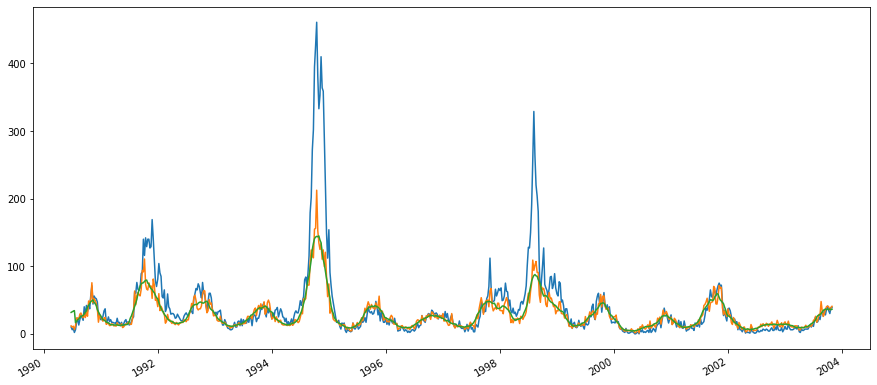

In [163]:
evaluate_pred_val(y_train, y_train_pred, y_train, w=9)

Raw:
--------------------
RMSE: 23.21
--------------------
MAE: 15.99
Explained variance: 0.376
--------------------

With smoothing:
--------------------
RMSE: 21.38
--------------------
MAE: 15.0
Explained variance: 0.475
--------------------


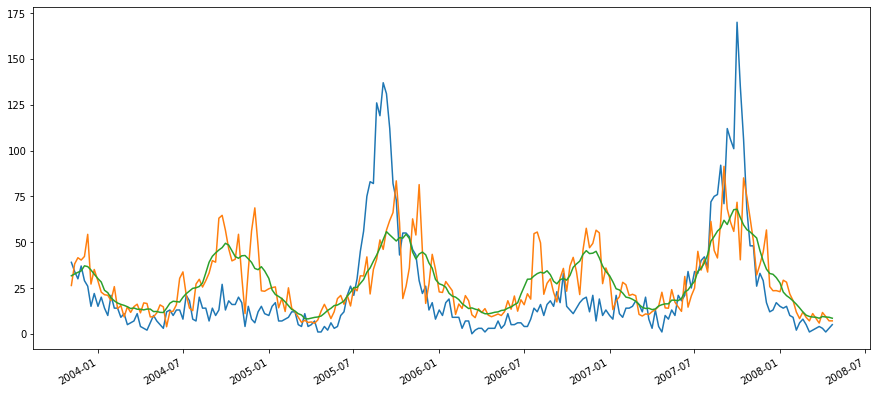

In [164]:
evaluate_pred_val(y_test, y_test_pred, y_train, w=9)

## Part 2: San Juan Test Data

### Feature selection

In [165]:
env_features = get_env_features(sj_train)

In [166]:
my_features = get_highest_corr_features(sj_train, 7)

### Preprocessing for Sklearn

In [167]:
X_train = sj_train[my_features].dropna()
X_test = sj_test[my_features].dropna()

y_train = custom_dropper(sj_train, my_features).total_cases

### Scaling

In [168]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Logarithmising

In [169]:
# adding 1 to avoid log(0)
y_train = np.log(y_train+1)

### Regression

In [170]:
rf = RandomForestRegressor(max_depth=10)

In [171]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10)

In [172]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

### Postprocessing

In [173]:
# Train part
y_train_pred = pd.Series(np.exp(y_train_pred))
y_train_pred -= 1
y_train_pred.index = y_train.index

y_train = np.exp(y_train)
y_train -= 1

# Test part
y_test_pred = pd.Series(np.exp(y_test_pred))
y_test_pred -= 1
y_test_pred.index = sj_test.index

y_test = np.exp(y_test)
y_test -= 1

### Evaluation

Raw:
--------------------
RMSE: 33.04
--------------------
MAE: 13.43
Explained variance: 0.621
--------------------

With smoothing:
--------------------
RMSE: 34.55
--------------------
MAE: 14.1
Explained variance: 0.583
--------------------


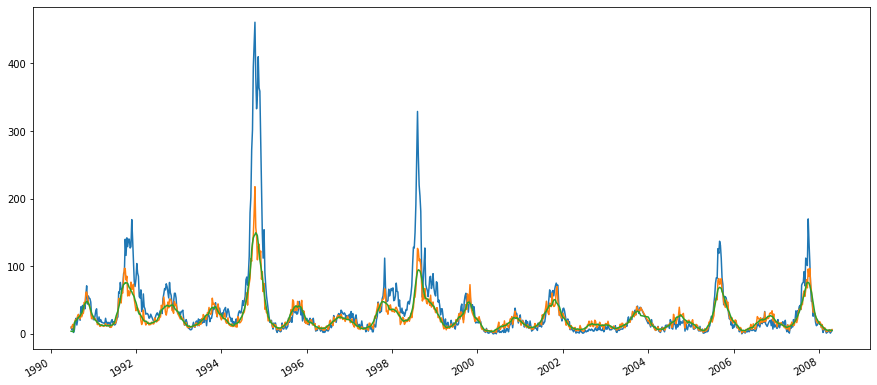

In [174]:
evaluate_pred_val(y_train, y_train_pred, y_train, w=9)

In [189]:
def evaluate_pred_test(y_pred, y_train, w):
    y_pred.plot(color='C01')
    lossless_centered_smoothing(y_pred, y_train, w=w).plot(color='C02');

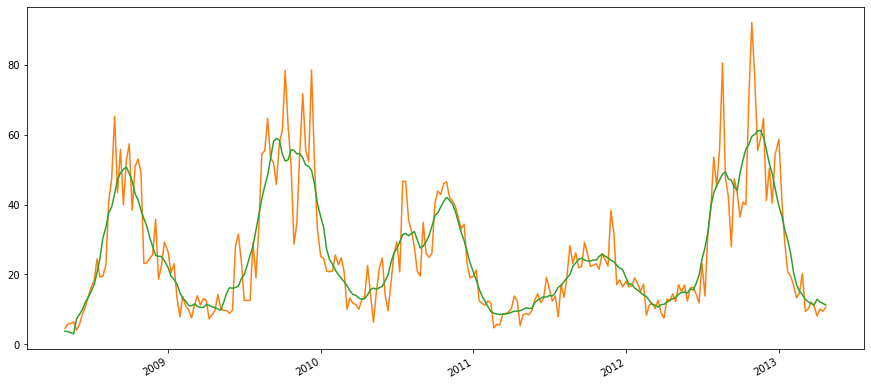

In [190]:
evaluate_pred_test(y_test_pred, y_train, w=9)

In [192]:
# Save the predictions for the submission
sj_pred_subm = lossless_centered_smoothing(y_test_pred, y_train, w=9)

## Part 3: Iquitos Validation

### Feature selection

In [194]:
env_features = get_env_features(iq_train_train)

In [195]:
my_features = get_highest_corr_features(iq_train_train, 7)

### Preprocessing for Sklearn

In [196]:
X_train = iq_train_train[my_features].dropna()
X_test = iq_train_test[my_features].dropna()

y_train = custom_dropper(iq_train_train, my_features).total_cases
y_test = custom_dropper(iq_train_test, my_features).total_cases

### Scaling

In [197]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Logarithmising

In [198]:
# adding 1 to avoid log(0)
y_train = np.log(y_train+1)
y_test = np.log(y_test+1)

### Regression

In [199]:
rf = RandomForestRegressor(max_depth=10)

In [200]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10)

In [201]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

### Postprocessing

In [202]:
# Train part
y_train_pred = pd.Series(np.exp(y_train_pred))
y_train_pred -= 1
y_train_pred.index = y_train.index

y_train = np.exp(y_train)
y_train -= 1

# Test part
y_test_pred = pd.Series(np.exp(y_test_pred))
y_test_pred -= 1
y_test_pred.index = y_test.index

y_test = np.exp(y_test)
y_test -= 1

### Evaluation

Raw:
--------------------
RMSE: 6.89
--------------------
MAE: 3.19
Explained variance: 0.655
--------------------

With smoothing:
--------------------
RMSE: 8.86
--------------------
MAE: 4.23
Explained variance: 0.408
--------------------


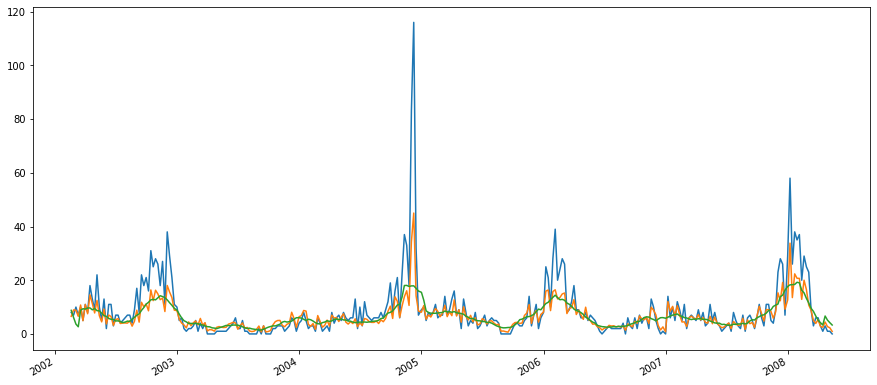

In [204]:
evaluate_pred_val(y_train, y_train_pred, y_train, w=9)

Raw:
--------------------
RMSE: 11.91
--------------------
MAE: 7.07
Explained variance: -0.043
--------------------

With smoothing:
--------------------
RMSE: 11.76
--------------------
MAE: 6.85
Explained variance: -0.02
--------------------


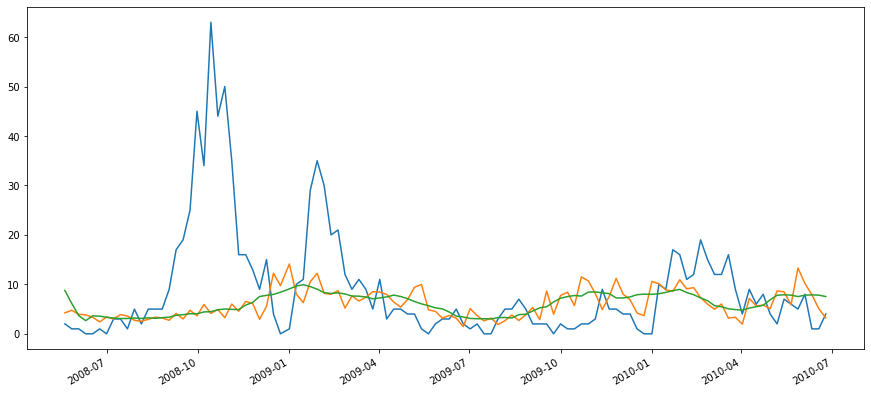

In [205]:
evaluate_pred_val(y_test, y_test_pred, y_train, w=9)

## Part 3: Iquitos Test Data

### Feature selection

In [218]:
env_features = get_env_features(iq_train)

In [219]:
my_features = get_highest_corr_features(iq_train, 7)

### Preprocessing for Sklearn

In [220]:
X_train = iq_train[my_features].dropna()
X_test = iq_test[my_features].dropna()

y_train = custom_dropper(iq_train, my_features).total_cases

### Scaling

In [221]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Logarithmising

In [222]:
# adding 1 to avoid log(0)
y_train = np.log(y_train+1)

### Regression

In [223]:
rf = RandomForestRegressor(max_depth=10)

In [224]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10)

In [225]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

### Postprocessing

In [226]:
# Train part
y_train_pred = pd.Series(np.exp(y_train_pred))
y_train_pred -= 1
y_train_pred.index = y_train.index

y_train = np.exp(y_train)
y_train -= 1

# Test part
y_test_pred = pd.Series(np.exp(y_test_pred))
y_test_pred -= 1
y_test_pred.index = iq_test.index

y_test = np.exp(y_test)
y_test -= 1

/home/mario/neuefische/DenguePred/.venv/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Evaluation

Raw:
--------------------
RMSE: 7.41
--------------------
MAE: 3.58
Explained variance: 0.611
--------------------

With smoothing:
--------------------
RMSE: 8.96
--------------------
MAE: 4.42
Explained variance: 0.411
--------------------


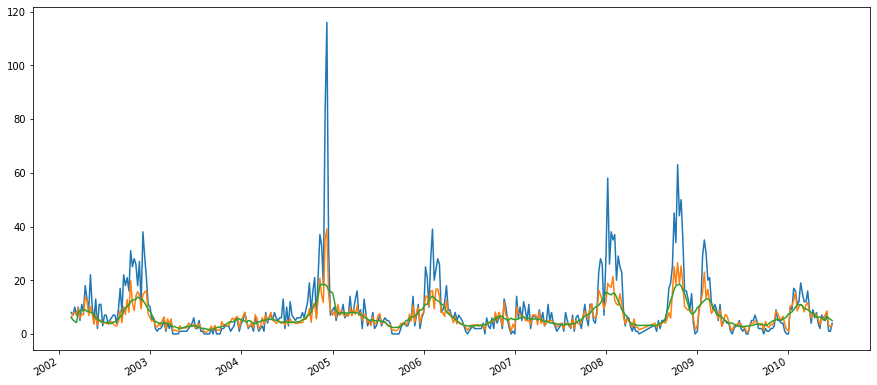

In [227]:
evaluate_pred_val(y_train, y_train_pred, y_train, w=9)

In [228]:
def evaluate_pred_test(y_pred, y_train, w):
    y_pred.plot(color='C01')
    lossless_centered_smoothing(y_pred, y_train, w=w).plot(color='C02');

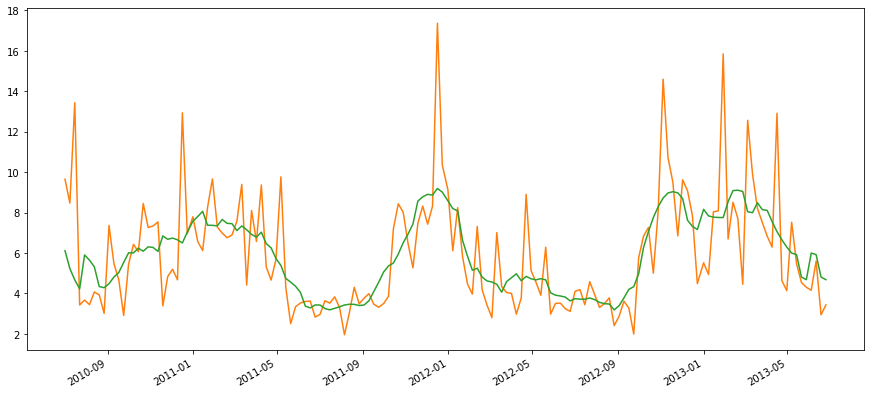

In [229]:
evaluate_pred_test(y_test_pred, y_train, w=9)

In [230]:
# Save the predictions for the submission
iq_pred_subm = lossless_centered_smoothing(y_test_pred, y_train, w=9)

## Submission

In [231]:
def subm_builder_ind_city(pred, test_df):
    pred = pred.reset_index().rename(columns={
        'index': 'week_start_date',
        0: 'total_cases'
    })
    subm_indcity = pd.merge(test_df[['city', 'year', 'weekofyear','week_start_date']], pred).drop('week_start_date', axis=1)
    return subm_indcity

def subm_builder(pred_1, test_df_1, pred_2, test_df_2):
    subm_city_1 = subm_builder_ind_city(pred_1, test_df_1)
    subm_city_2 = subm_builder_ind_city(pred_2, test_df_2)
    subm_table = pd.concat([subm_city_1, subm_city_2], axis=0)
    return subm_table

In [233]:
submission_df = subm_builder(sj_pred_subm, sj_test, iq_pred_subm, iq_test)
submission_df.total_cases = submission_df.total_cases.astype(int)
print(submission_df.total_cases.max())
submission_df

61


,city,year,weekofyear,total_cases
0,sj,2008,18,3
1,sj,2008,19,3
2,sj,2008,20,3
3,sj,2008,21,3
4,sj,2008,22,7
...,...,...,...,...
151,iq,2013,22,4
152,iq,2013,23,5
153,iq,2013,24,5
154,iq,2013,25,4


In [234]:
submission_df.to_csv('data/submission_simple_random_forest_7_feats.csv', index=False)

# Poisson Regression

### Imports

### Settings

In [5]:
pd.options.display.max_rows = 100 # For debugging, can be removed later

In [6]:
# Matplotlib configuration
plt.rcParams['figure.figsize'] = [15, 7]

### Helper functions
Sort out in the end!!!

In [7]:
def model_classification(actual, predicted):
    '''
    Prints out RSME, MAE and explained variance score
    '''
    print('-'*20)
    print(f'RMSE: {round(np.sqrt(mean_squared_error(actual, predicted)),2)}')
    print('-'*20)
    print(f'MAE: {round(mean_absolute_error(actual, predicted),2)}')
    print(f'Explained variance: {round(explained_variance_score(actual, predicted),3)}')
    print('-'*20)

In [8]:
def custom_dropper(df, cols):
    '''
    drops rows with NaNs from a dataframe based on their presence in a subset of the df
    '''
    return df[df.index.isin(df[cols].dropna().index)]
# custom_dropper(sj_train_train, my_features)

In [9]:
# This is a copy from above
def env_cols(df):
    '''
    Returns a list of only environmental variables (that can be lagged).
    '''
    cols = df.columns.to_list()
    unwanted = ['week_start_date',
                'city',
                'year',
                'weekofyear',
                'month',
                'total_cases',
                'total_cases_o_seas',
                'total_cases_wo_seas'
               ]
    return [e for e in cols if e not in unwanted]

In [10]:
def reduce_features_lda_border(df, df_train, cols, target, border=100):
    '''
    df
    cols
    '''
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(df_train[cols])
    df_scaled_train = pd.DataFrame(data=scaled_train, columns=cols)
    lda = LDA(n_components=1)
    lda.fit(df_scaled_train.dropna(),
                        np.where(custom_dropper(df_train, cols)[target] > border, 1, 0).tolist())
    
    scaled_test = scaler.transform(df[cols])
    df_scaled_test = pd.DataFrame(data=scaled_test, columns=cols)
    lda_comps = lda.transform(df_scaled_test.dropna())
    lda_df = pd.DataFrame(data = lda_comps)
    lda_df.index = df[cols].dropna().index
    return lda_df

In [11]:
def reduce_features_lda_bins(df, df_train, cols, target, n_comps=2, n_bins=2):
    '''
    df
    cols
    '''
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df_train[cols])
    df_scaled = pd.DataFrame(data=scaled, columns=cols)
    lda = LDA(n_components=n_comps)
    lda.fit(df_scaled.dropna(),
            pd.cut(custom_dropper(df_train, cols)[target], n_bins, labels=False))
    
    scaled_test = scaler.transform(df[cols])
    df_scaled_test = pd.DataFrame(data=scaled_test, columns=cols)
    lda_comps = lda.transform(df_scaled_test.dropna())
    lda_df = pd.DataFrame(data = lda_comps)
    lda_df.index = df[cols].dropna().index
    return lda_df

### Loading and preparing the data

In [12]:
sj_train_train, \
sj_train_test, \
sj_test, \
iq_train_train, \
iq_train_test, \
iq_test = pickle.load(open('data_subsets_lags.pickle', 'rb'))

In [13]:
sj_test.index.name = None
iq_test.index.name = None

In [14]:
sj_train = pd.concat([sj_train_train, sj_train_test], axis=0)
iq_train = pd.concat([iq_train_train, iq_train_test], axis=0)

In [15]:
def fill_from_train(df_test, df_train):
    null_cols = df_test.columns[df_test.isnull().any()]
    df_miss = df_test.loc[:,df_test[null_cols].columns]

    for i in range(df_miss.shape[1]):
        colname_miss = df_miss.iloc[:,i].name
        n_miss = df_miss.iloc[:,i].isnull().sum()
        data_for_gap = df_train.loc[:,colname_miss].iloc[-n_miss:]
        df_test.loc[:, colname_miss][df_test.loc[:, colname_miss].isnull()] = data_for_gap.values

    return df_test

In [16]:
sj_train_test = fill_from_train(sj_train_test, sj_train_train)
iq_train_test = fill_from_train(iq_train_test, iq_train_train)

sj_test = fill_from_train(sj_test, sj_train)
iq_test = fill_from_train(iq_test, iq_train)

/tmp/ipykernel_407058/2268118587.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, colname_miss][df_test.loc[:, colname_miss].isnull()] = data_for_gap.values


## Part 1: San Juan Validation

### Feature selection

In [17]:
def get_env_features(df):
    return (
        df.drop([
          'total_cases',
           'week_start_date',
           'city',
           'year',
           'weekofyear'
        ], axis=1)
        .columns
        .to_list()
    )
env_features = get_env_features(sj_train_train)

In [20]:
def get_highest_corr_features(df, n):
    corr_mat = df.corr()
    return (
        corr_mat['total_cases']
        .drop([
            'total_cases',
            'year',
            'weekofyear'])
        .abs()
        .sort_values()
        .tail(n)
        .index
    )
my_features = get_highest_corr_features(sj_train_train, 50)

### Preprocessing for Sklearn

In [21]:
X_train = sj_train_train[my_features].dropna()
X_test = sj_train_test[my_features].dropna()

y_train = custom_dropper(sj_train_train, my_features).total_cases
y_test = custom_dropper(sj_train_test, my_features).total_cases

### Scaling

In [22]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Regression

In [25]:
pr = HistGradientBoostingRegressor(loss='poisson')

In [26]:
pr.fit(X_train, y_train)

HistGradientBoostingRegressor(loss='poisson')

In [27]:
y_train_pred = pr.predict(X_train)
y_test_pred = pr.predict(X_test)

### Postprocessing

In [28]:
# Train part
y_train_pred = pd.Series(y_train_pred)
y_train_pred.index = y_train.index

# Test part
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = y_test.index

### Smoothing

In [29]:
def lossless_centered_smoothing(test_pred, train_y, w=3):
    if w // 2 == 0:
        print('w has to be an odd number to keep things simple while still doing centered smoothing')
        return
    else:
        
        trunk = train_y.rolling(window=w).mean()[-int((w-1) / 2):]
        tail = test_pred.rolling(window=w).mean()[-int((w-1) / 2):]

        smoothed = test_pred.rolling(window=w, center=True).mean()
        smoothed[:int((w-1) / 2)] = trunk
        smoothed[-int((w-1) / 2):] = tail

    return smoothed

### Evaluation

In [30]:
def evaluate_pred_val(y, y_pred, y_train, w):
    y.plot()
    y_pred.plot()
    lossless_centered_smoothing(y_pred, y_train, w=w).plot();
    print('Raw:')
    model_classification(y, y_pred)
    print('\nWith smoothing:')
    model_classification(y, lossless_centered_smoothing(y_pred, y_train, w=w))

Raw:
--------------------
RMSE: 5.73
--------------------
MAE: 4.18
Explained variance: 0.99
--------------------

With smoothing:
--------------------
RMSE: 14.01
--------------------
MAE: 8.16
Explained variance: 0.939
--------------------


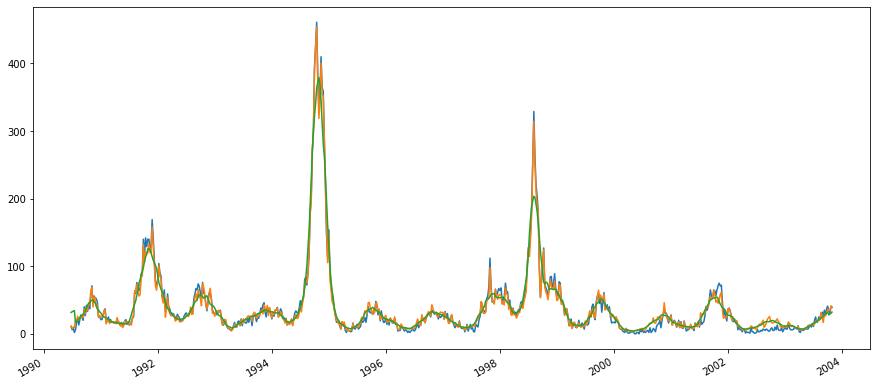

In [31]:
evaluate_pred_val(y_train, y_train_pred, y_train, w=9)

Raw:
--------------------
RMSE: 26.52
--------------------
MAE: 18.19
Explained variance: 0.16
--------------------

With smoothing:
--------------------
RMSE: 24.93
--------------------
MAE: 17.31
Explained variance: 0.26
--------------------


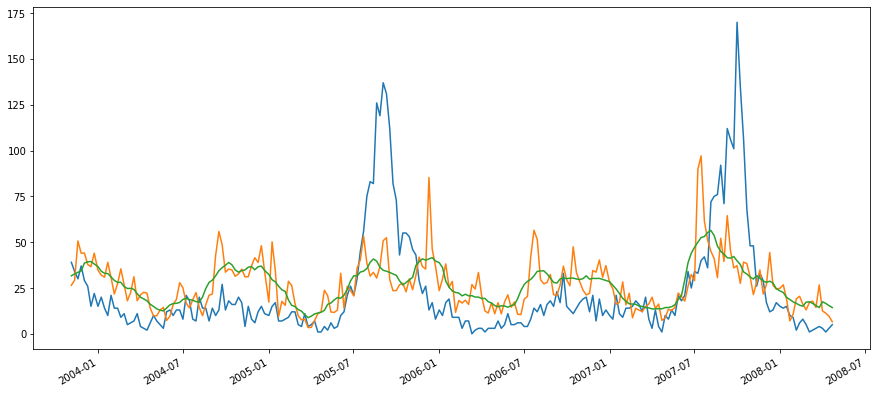

In [32]:
evaluate_pred_val(y_test, y_test_pred, y_train, w=9)

## Part 2: San Juan Test Data

### Feature selection

In [33]:
env_features = get_env_features(sj_train)

In [34]:
my_features = get_highest_corr_features(sj_train, 50)

### Preprocessing for Sklearn

In [35]:
X_train = sj_train[my_features].dropna()
X_test = sj_test[my_features].dropna()

y_train = custom_dropper(sj_train, my_features).total_cases

### Scaling

In [36]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Regression

In [37]:
pr = HistGradientBoostingRegressor(loss='poisson')

In [38]:
pr.fit(X_train, y_train)

HistGradientBoostingRegressor(loss='poisson')

In [39]:
y_train_pred = pr.predict(X_train)
y_test_pred = pr.predict(X_test)

### Postprocessing

In [40]:
# Train part
y_train_pred = pd.Series(y_train_pred)
y_train_pred.index = y_train.index

# Test part
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = sj_test.index

### Evaluation

Raw:
--------------------
RMSE: 4.85
--------------------
MAE: 3.67
Explained variance: 0.991
--------------------

With smoothing:
--------------------
RMSE: 12.61
--------------------
MAE: 7.22
Explained variance: 0.941
--------------------


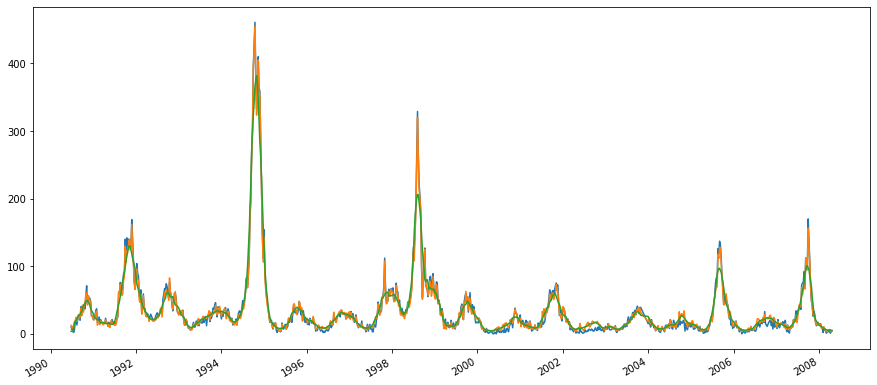

In [41]:
evaluate_pred_val(y_train, y_train_pred, y_train, w=9)

In [42]:
def evaluate_pred_test(y_pred, y_train, w):
    y_pred.plot(color='C01')
    lossless_centered_smoothing(y_pred, y_train, w=w).plot(color='C02');

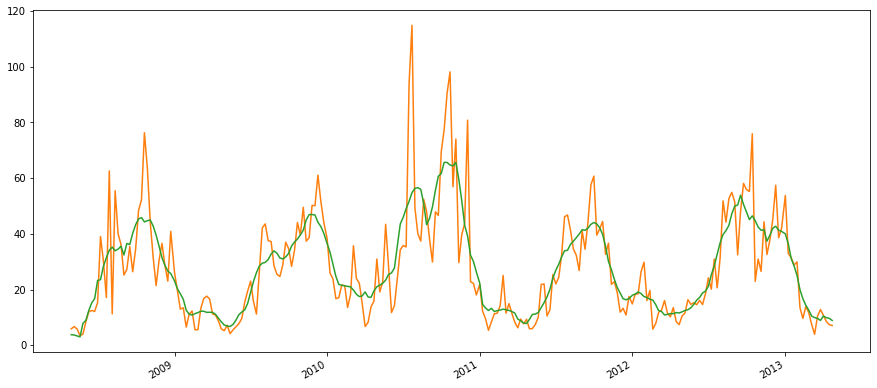

In [43]:
evaluate_pred_test(y_test_pred, y_train, w=9)

In [44]:
# Save the predictions for the submission
sj_pred_subm = lossless_centered_smoothing(y_test_pred, y_train, w=9)

## Part 3: Iquitos Validation

### Feature selection

In [45]:
env_features = get_env_features(iq_train_train)

In [46]:
my_features = get_highest_corr_features(iq_train_train, 50)

### Preprocessing for Sklearn

In [47]:
X_train = iq_train_train[my_features].dropna()
X_test = iq_train_test[my_features].dropna()

y_train = custom_dropper(iq_train_train, my_features).total_cases
y_test = custom_dropper(iq_train_test, my_features).total_cases

### Scaling

In [48]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Regression

In [49]:
pr = HistGradientBoostingRegressor(loss='poisson')

In [50]:
pr.fit(X_train, y_train)

HistGradientBoostingRegressor(loss='poisson')

In [51]:
y_train_pred = pr.predict(X_train)
y_test_pred = pr.predict(X_test)

### Postprocessing

In [52]:
# Train part
y_train_pred = pd.Series(y_train_pred)
y_train_pred.index = y_train.index

# Test part
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = y_test.index

### Evaluation

Raw:
--------------------
RMSE: 1.41
--------------------
MAE: 1.08
Explained variance: 0.984
--------------------

With smoothing:
--------------------
RMSE: 6.96
--------------------
MAE: 3.59
Explained variance: 0.615
--------------------


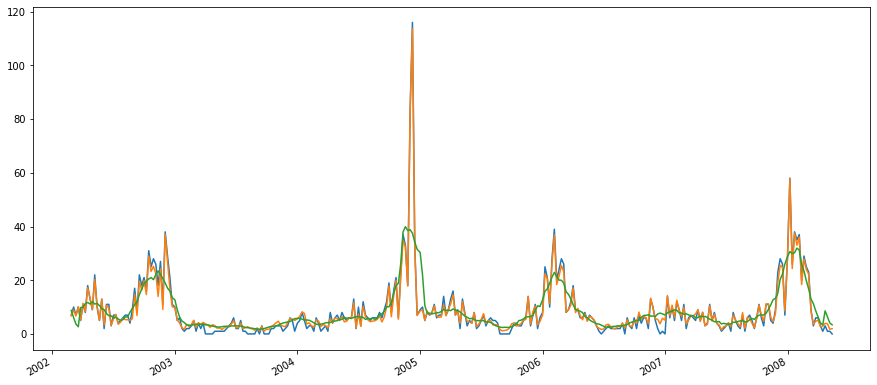

In [53]:
evaluate_pred_val(y_train, y_train_pred, y_train, w=9)

Raw:
--------------------
RMSE: 11.31
--------------------
MAE: 6.96
Explained variance: 0.012
--------------------

With smoothing:
--------------------
RMSE: 11.24
--------------------
MAE: 6.86
Explained variance: 0.022
--------------------


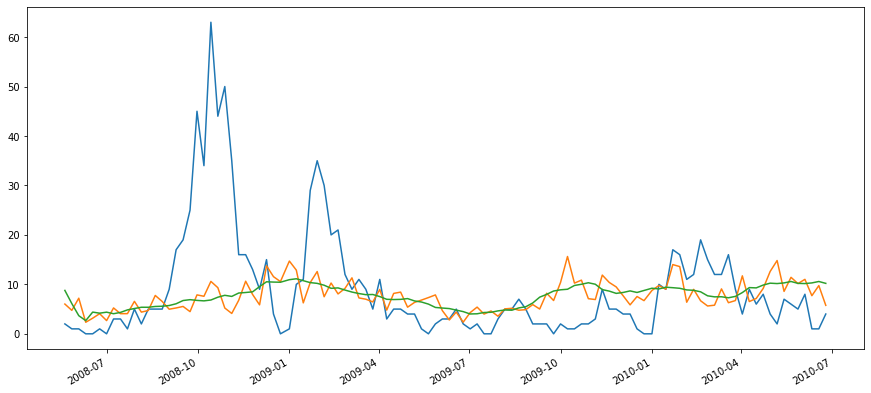

In [54]:
evaluate_pred_val(y_test, y_test_pred, y_train, w=9)

## Part 3: Iquitos Test Data

### Feature selection

In [55]:
env_features = get_env_features(iq_train)

In [58]:
my_features = get_highest_corr_features(iq_train, 50)

### Preprocessing for Sklearn

In [59]:
X_train = iq_train[my_features].dropna()
X_test = iq_test[my_features].dropna()

y_train = custom_dropper(iq_train, my_features).total_cases

### Scaling

In [60]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Regression

In [61]:
pr = HistGradientBoostingRegressor(loss='poisson')

In [62]:
pr.fit(X_train, y_train)

HistGradientBoostingRegressor(loss='poisson')

In [63]:
y_train_pred = pr.predict(X_train)
y_test_pred = pr.predict(X_test)

### Postprocessing

In [64]:
# Train part
y_train_pred = pd.Series(y_train_pred)
y_train_pred.index = y_train.index

# Test part
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = iq_test.index

### Evaluation

Raw:
--------------------
RMSE: 1.41
--------------------
MAE: 1.1
Explained variance: 0.984
--------------------

With smoothing:
--------------------
RMSE: 6.63
--------------------
MAE: 3.58
Explained variance: 0.655
--------------------


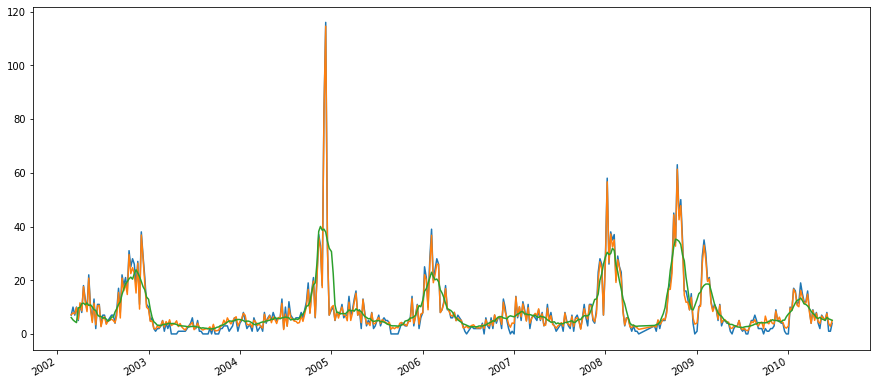

In [65]:
evaluate_pred_val(y_train, y_train_pred, y_train, w=9)

In [66]:
def evaluate_pred_test(y_pred, y_train, w):
    y_pred.plot(color='C01')
    lossless_centered_smoothing(y_pred, y_train, w=w).plot(color='C02');

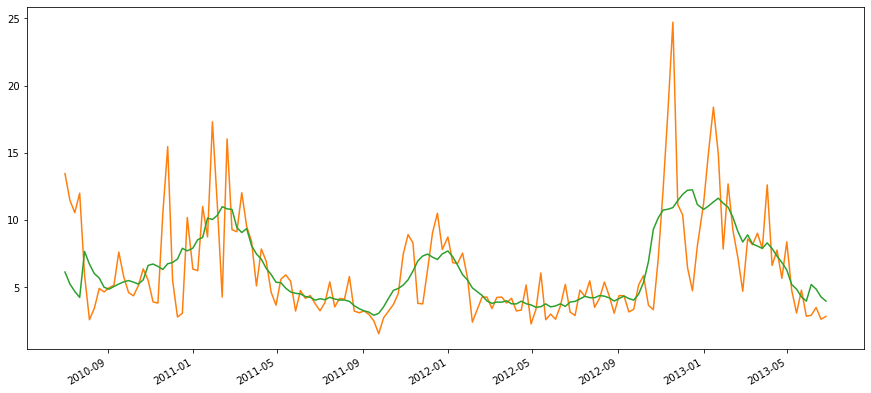

In [67]:
evaluate_pred_test(y_test_pred, y_train, w=9)

In [68]:
# Save the predictions for the submission
iq_pred_subm = lossless_centered_smoothing(y_test_pred, y_train, w=9)

## Submission

In [69]:
def subm_builder_ind_city(pred, test_df):
    pred = pred.reset_index().rename(columns={
        'index': 'week_start_date',
        0: 'total_cases'
    })
    subm_indcity = pd.merge(test_df[['city', 'year', 'weekofyear','week_start_date']], pred).drop('week_start_date', axis=1)
    return subm_indcity

def subm_builder(pred_1, test_df_1, pred_2, test_df_2):
    subm_city_1 = subm_builder_ind_city(pred_1, test_df_1)
    subm_city_2 = subm_builder_ind_city(pred_2, test_df_2)
    subm_table = pd.concat([subm_city_1, subm_city_2], axis=0)
    return subm_table

In [70]:
submission_df = subm_builder(sj_pred_subm, sj_test, iq_pred_subm, iq_test)
submission_df.total_cases = submission_df.total_cases.astype(int)
print(submission_df.total_cases.max())
submission_df

65


,city,year,weekofyear,total_cases
0,sj,2008,18,3
1,sj,2008,19,3
2,sj,2008,20,3
3,sj,2008,21,3
4,sj,2008,22,7
...,...,...,...,...
151,iq,2013,22,3
152,iq,2013,23,5
153,iq,2013,24,4
154,iq,2013,25,4


In [72]:
submission_df.to_csv('data/submission_poisson_gradient_boosting_50.csv', index=False)